
Probability of heart disease given old age:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.4577 |
+-----------+---------------+
| target(1) |        0.5423 |
+-----------+---------------+

Probability of heart disease given young age:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.4534 |
+-----------+---------------+
| target(1) |        0.5466 |
+-----------+---------------+

Cholesterol distribution given heart disease and high fasting blood sugar:
+------------+-------------+
| chol       |   phi(chol) |
+============+=============+
| chol(high) |      0.0305 |
+------------+-------------+
| chol(low)  |      0.9695 |
+------------+-------------+

Max heart rate distribution given no heart disease:
+---------------+----------------+
| thalach       |   phi(thalach) |
+===============+================+
| thalach(high) |         0.5725 |
+---------------

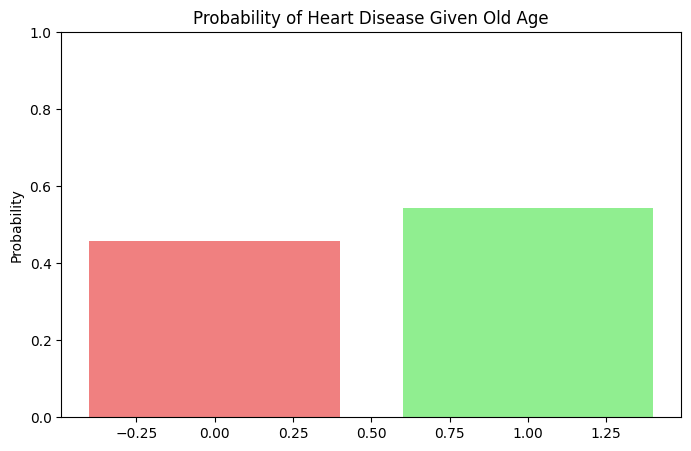

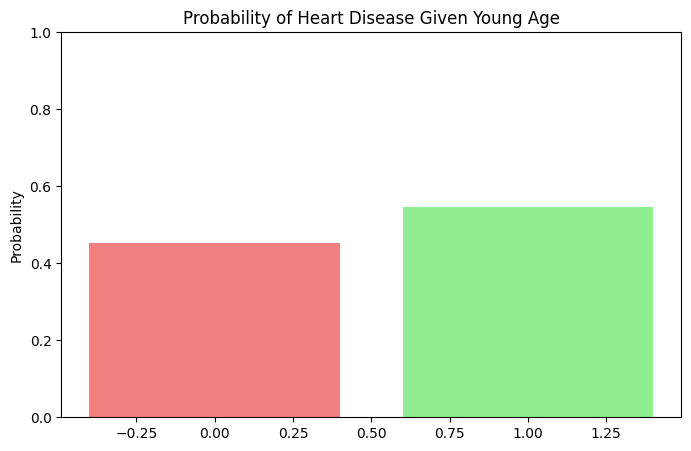

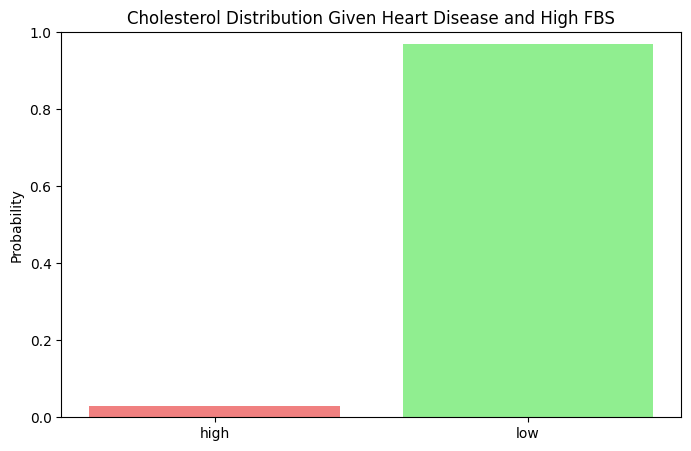

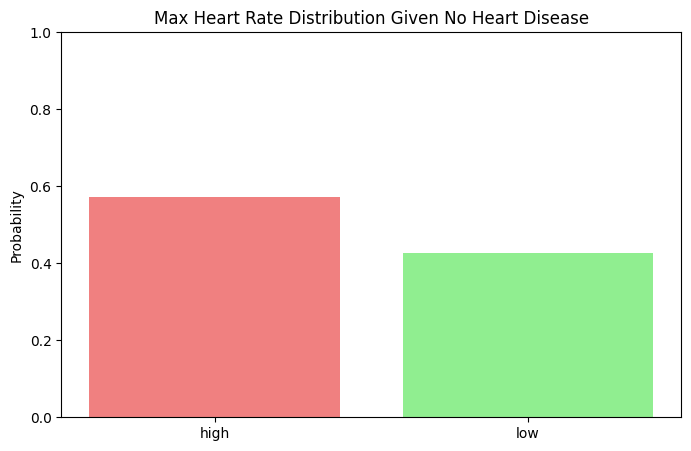

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/aiplanethub/Datasets/master/heart_disease.csv"
df = pd.read_csv(url)

df = df.drop_duplicates()
df = df.dropna()

numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

model = DiscreteBayesianNetwork([
    ('age', 'fbs'),
    ('fbs', 'target'),
    ('target', 'chol'),
    ('target', 'thalach')
])

df_discrete = df.copy()
df_discrete['age'] = pd.cut(df['age'], bins=3, labels=['young', 'middle', 'old'])
df_discrete['chol'] = pd.cut(df['chol'], bins=2, labels=['low', 'high'])
df_discrete['thalach'] = pd.cut(df['thalach'], bins=2, labels=['low', 'high'])

model.fit(df_discrete, estimator=MaximumLikelihoodEstimator)

# for cpd in model.get_cpds():
#     print(f"\nCPD for {cpd.variable}:")
#     print(cpd)

infer = VariableElimination(model)

# Probability of heart disease (target=1) given age='old'
prob_heart_disease_given_old = infer.query(variables=['target'], evidence={'age': 'old'})
print("\nProbability of heart disease given old age:")
print(prob_heart_disease_given_old)

# Probability of heart disease (target=1) given age='young'
prob_heart_disease_given_young = infer.query(variables=['target'], evidence={'age': 'young'})
print("\nProbability of heart disease given young age:")
print(prob_heart_disease_given_young)

# Cholesterol distribution when target=1 (heart disease) and fbs=1 (high fasting blood sugar)
chol_dist = infer.query(variables=['chol'], evidence={'target': 1, 'fbs': 1})
print("\nCholesterol distribution given heart disease and high fasting blood sugar:")
print(chol_dist)

# Most likely thalach value when target=0 (no heart disease)
thalach_dist = infer.query(variables=['thalach'], evidence={'target': 0})
print("\nMax heart rate distribution given no heart disease:")
print(thalach_dist,"\n")

def plot_prob_distribution(prob_dist, title):
    values = prob_dist.state_names[prob_dist.variables[0]]
    probs = prob_dist.values

    plt.figure(figsize=(8, 5))
    plt.bar(values, probs, color=['lightcoral', 'lightgreen'])
    plt.title(title)
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.show()

plot_prob_distribution(prob_heart_disease_given_old,
                      "Probability of Heart Disease Given Old Age")
plot_prob_distribution(prob_heart_disease_given_young,
                      "Probability of Heart Disease Given Young Age")
plot_prob_distribution(chol_dist,
                      "Cholesterol Distribution Given Heart Disease and High FBS")
plot_prob_distribution(thalach_dist,
                      "Max Heart Rate Distribution Given No Heart Disease")